## Hello world on 2 qubit bell state

In [ ]:
from qiskit import QuantumCircuit, assemble
from qiskit.visualization import *
from qiskit_ibm_runtime import *
import numpy as np

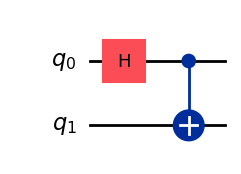

In [12]:
# step 1: mapping the problem to quantum circuits

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1) #control bit is 0 and target bit is 1
qc.draw(output='mpl')

In [13]:
from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')

XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

observables = [ZZ, ZI, IZ, XX, XI, IX]



In [1]:
# step 2: optimize (as we are runnning this on the lcoal aer simulator, we don't need this step)

# step 3: Execute on the backend

from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

NameError: name 'qc' is not defined

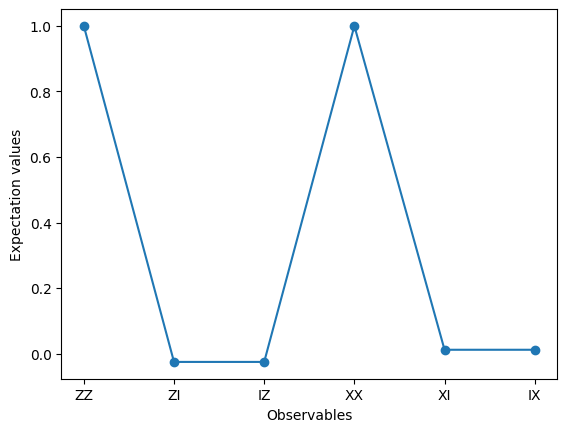

In [15]:
#step 4: Post process (and Plotting)

import matplotlib.pyplot as plt

data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']
values = job.result().values

plt.plot(data, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation values')
plt.show()

## Hello World on the $n$ qubit GHZ-state

In [16]:
# step 1: mapping the problem to quantum circuits and operators

def prepare_n_qubit_ghz_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(i, i+1)
    return qc

n = 100
qc = prepare_n_qubit_ghz_state(n)
# qc.draw(output='mpl')

*we are going  to design operators and check how much noise is there between the first and the next qubit. what we expect is as the distance between the qubit in the quantum circuit increases the noise will increase*

In [17]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = ['Z' + 'I' * i + 'Z' + 'I' * (n-2-i) for i in range(n-1)]
print(operator_strings)
print(len(operator_strings))


opertors = [SparsePauliOp(operator_string) for operator_string in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [18]:
# step 2: optimize the problem for quantum execution

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend_name = "ibm_brisbane"
backend  =  QiskitRuntimeService().get_backend(backend_name)
# backend = QiskitRuntimeService(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pass_manager.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in opertors]




AttributeError: 'QiskitRuntimeService' object has no attribute 'get_backend'

In [ ]:
# step 3: execute on the backend

from qiskit_ibm_runtime import EstimatorV2 as Estimator, EstimatorOptions

options = EstimatorOptions()

options.resilience_level = 1
options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options)

job = estimator.run([(qc_transpiled, operators_transpiled_list)])
job_id = job.job_id()

print(job_id)




C:\Users\kafar\AppData\Local\Temp\ipykernel_25988\3854092504.py:12: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(backend, options)


cxstych3wrp0008kqx50


In [ ]:
# step 4: post process and plot
import matplotlib.pyplot as plt

job_id = 'cxstych3wrp0008kqx50'
job = QiskitRuntimeService().job(job_id)

data = list(range(1, len(opertors) +1 ))
values = job.result()[0].data.evs
values = [v / values[0] for v in values]

plt.scatter(data, values, 'o', label='100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'\langle Z_0 Z_i \rangle / \langle Z_0  Z_1 \rangle$')
